In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision

In [2]:
input_path = "C:/Users/AS-GP/Desktop/Resnet50/lisat_gaze_data_v1/lisat_gaze_data_mixed/"

In [3]:
from torch.utils.data import random_split

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
}
full_dataset = datasets.ImageFolder(input_path + 
                                    '/train', 
                                    data_transforms['train'])

# Calculate the sizes of the training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders for training and validation sets
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset,
                                         batch_size=32,
                                         shuffle=True,
                                         num_workers=2),
    'validation': torch.utils.data.DataLoader(val_dataset,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=2)
}
print(len(train_dataset))
print(len(val_dataset))

24004
6001


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
model =torchvision.models.mobilenet_v3_small(pretrained=True).to(device)
model

C:\Users\AS-GP\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\AS-GP/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 9.83M/9.83M [00:00<00:00, 16.4MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [14]:
model =torchvision.models.mobilenet_v3_small(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

# Define constants
NUM_CLASSES = 8
INPUT_FEATURES = 576
HIDDEN_FEATURES = 1024
OUTPUT_FEATURES = 1280

# Define the custom classifier
classifier = nn.Sequential(
    nn.Linear(INPUT_FEATURES, HIDDEN_FEATURES, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(HIDDEN_FEATURES, OUTPUT_FEATURES, bias=True),
    nn.Linear(OUTPUT_FEATURES, NUM_CLASSES, bias=True),  # Output layer with 8 classes
    nn.Softmax(dim=1)
)

# Replace the default classifier with the custom one
model.classifier = classifier

model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(),lr=0.0001)

In [16]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = 0

    def early_stop(self, current_accuracy):
        if (current_accuracy > self.best_accuracy + self.min_delta):
            self.best_accuracy = current_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [17]:
weights_path='MNV3_small_weights.h5'

In [18]:
early_stopper = EarlyStopper(10,0.01)
def train_model(model, criterion, optimizer, num_epochs=5):
    training_accuracies = []
    validation_accuracies = []
    training_accuracies.append(0)
    validation_accuracies.append(0)
    #optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train().to(device) #added to device
            else:
                model.eval().to(device)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs).to(device)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                epoch_loss = running_loss / len(train_dataset)
                epoch_acc = running_corrects.double() / len(train_dataset)
                training_accuracies.append(epoch_acc.item()*100)
            else:
                epoch_loss = running_loss / len(val_dataset)
                epoch_acc = running_corrects.double() / len(val_dataset)
                validation_accuracies.append(epoch_acc.item()*100)
                if early_stopper.early_stop(epoch_acc.item()*100):
                    print('triggered ES Tacc: {:.4f}, Vacc: {:.4f}'.format(training_accuracies[-1], 
                                                                           validation_accuracies[-1]))            
                    return model,training_accuracies,validation_accuracies
            
                if epoch_acc.item()*100 >= early_stopper.best_accuracy:
                    #early_stopper.early_stop(epoch_acc.item()*100)
                    #early_stopper.best_accuracy = epoch_acc.item()*100
                    print('best accuracy {:.4f}'.format(early_stopper.best_accuracy))
                    torch.save(model.state_dict(), weights_path)
                    print(f"Model saved as it achieved the best validation accuracy so far {early_stopper.best_accuracy}" )

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model,training_accuracies,validation_accuracies 

In [19]:
model_trained = train_model(model, criterion, optimizer, num_epochs=100) #1 epoch for testing gpu

Epoch 1/100
----------
train loss: 1.7401, acc: 0.5507
best accuracy 70.6716
Model saved as it achieved the best validation accuracy so far 70.67155474087653
validation loss: 1.5894, acc: 0.7067
Epoch 2/100
----------
train loss: 1.5862, acc: 0.6991
best accuracy 75.0375
Model saved as it achieved the best validation accuracy so far 75.0374937510415
validation loss: 1.5302, acc: 0.7504
Epoch 3/100
----------
train loss: 1.5431, acc: 0.7395
best accuracy 78.7202
Model saved as it achieved the best validation accuracy so far 78.7202132977837
validation loss: 1.4934, acc: 0.7872
Epoch 4/100
----------
train loss: 1.5252, acc: 0.7535
best accuracy 80.2200
Model saved as it achieved the best validation accuracy so far 80.21996333944344
validation loss: 1.4792, acc: 0.8022
Epoch 5/100
----------
train loss: 1.5101, acc: 0.7702
validation loss: 1.4834, acc: 0.7947
Epoch 6/100
----------
train loss: 1.5003, acc: 0.7784
best accuracy 81.1698
Model saved as it achieved the best validation accura

train loss: 1.4116, acc: 0.8625
validation loss: 1.3858, acc: 0.8877
Epoch 65/100
----------
train loss: 1.4086, acc: 0.8647
validation loss: 1.3926, acc: 0.8810
Epoch 66/100
----------
train loss: 1.4094, acc: 0.8644
validation loss: 1.3981, acc: 0.8742
Epoch 67/100
----------
train loss: 1.4168, acc: 0.8571
validation loss: 1.3893, acc: 0.8855
Epoch 68/100
----------
train loss: 1.4099, acc: 0.8632
validation loss: 1.3855, acc: 0.8869
Epoch 69/100
----------
train loss: 1.4083, acc: 0.8645
validation loss: 1.3869, acc: 0.8877
Epoch 70/100
----------
train loss: 1.4069, acc: 0.8666
best accuracy 89.4851
Model saved as it achieved the best validation accuracy so far 89.48508581903016
validation loss: 1.3787, acc: 0.8949
Epoch 71/100
----------
train loss: 1.4053, acc: 0.8689
validation loss: 1.3889, acc: 0.8852
Epoch 72/100
----------
train loss: 1.4097, acc: 0.8639
validation loss: 1.3811, acc: 0.8922
Epoch 73/100
----------
train loss: 1.4046, acc: 0.8690
validation loss: 1.3955, acc

In [23]:
classes_labels = ['Eyes Closed','Forward','Left Mirror','Radio','Rearview','Right Mirror','Shoulder','Speedometer']

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(model, dataloader, num_classes):
    """
    Plots a confusion matrix for the given PyTorch model and validation data loader.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        dataloader (torch.utils.data.DataLoader): The validation data loader.
        num_classes (int): The number of classes in the dataset.

    Returns:
        None
    """

    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store the true and predicted labels
    true_labels = []
    pred_labels = []

    # Iterate over the validation dataset
    with torch.no_grad():
        for images, labels in dataloader:

            # Move the input tensor to the same device as the model weights
            if next(model.parameters()).is_cuda:
                images = images.cuda()

            # Forward pass
            outputs = model(images)

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)


            # Store the true and predicted labels
            true_labels += labels.cpu().numpy().tolist()
            pred_labels += predicted.cpu().numpy().tolist()

    print(true_labels)
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.imshow(cm, cmap='Blues')
    plt.xticks(range(num_classes),classes_labels)
    plt.yticks(range(num_classes),classes_labels)
    cm = np.around(cm.astype('float')/cm.sum(axis=1)[:,np.newaxis],decimals=2)
    plt.colorbar()
    plt.clim(0, max(cm.max(), cm.sum()))
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > thresh else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)


    plt.tight_layout()
    plt.ylim(num_classes, -0.5)
    plt.show()
    

[7, 4, 0, 3, 3, 3, 2, 5, 7, 6, 4, 1, 6, 1, 5, 0, 2, 3, 1, 1, 5, 6, 1, 6, 1, 6, 5, 6, 0, 2, 3, 7, 3, 4, 0, 1, 7, 4, 1, 3, 1, 6, 0, 1, 6, 7, 7, 2, 6, 1, 1, 1, 2, 0, 6, 4, 7, 6, 3, 6, 2, 5, 5, 2, 4, 6, 6, 6, 4, 0, 1, 5, 0, 1, 6, 0, 7, 3, 2, 4, 6, 6, 2, 6, 6, 6, 7, 7, 5, 4, 6, 1, 0, 0, 6, 0, 5, 1, 4, 0, 6, 6, 2, 6, 6, 2, 1, 7, 1, 2, 4, 6, 5, 5, 6, 2, 2, 2, 6, 3, 6, 4, 7, 6, 3, 4, 7, 6, 3, 3, 2, 4, 6, 6, 1, 0, 6, 0, 3, 7, 3, 4, 2, 7, 7, 6, 1, 5, 1, 3, 0, 7, 7, 3, 7, 1, 5, 5, 1, 6, 3, 6, 2, 5, 2, 7, 0, 0, 6, 6, 6, 5, 2, 3, 2, 4, 2, 7, 3, 5, 6, 5, 0, 3, 3, 4, 4, 1, 6, 2, 7, 5, 5, 0, 4, 6, 1, 2, 7, 3, 4, 4, 6, 6, 6, 4, 6, 3, 4, 4, 6, 3, 5, 7, 0, 3, 6, 2, 3, 1, 0, 6, 1, 6, 7, 4, 6, 0, 6, 2, 6, 7, 6, 0, 1, 4, 0, 4, 1, 5, 3, 6, 6, 5, 6, 5, 7, 1, 4, 5, 1, 1, 6, 1, 2, 5, 2, 5, 7, 5, 6, 6, 6, 6, 1, 6, 6, 1, 1, 7, 1, 7, 2, 2, 0, 6, 5, 3, 6, 6, 0, 0, 1, 0, 2, 1, 6, 1, 2, 6, 1, 6, 0, 3, 2, 3, 1, 5, 7, 7, 0, 6, 3, 2, 4, 7, 0, 2, 6, 5, 1, 0, 0, 5, 4, 6, 6, 5, 4, 7, 6, 6, 4, 1, 7, 4, 6, 1, 1, 7, 1, 2, 3, 

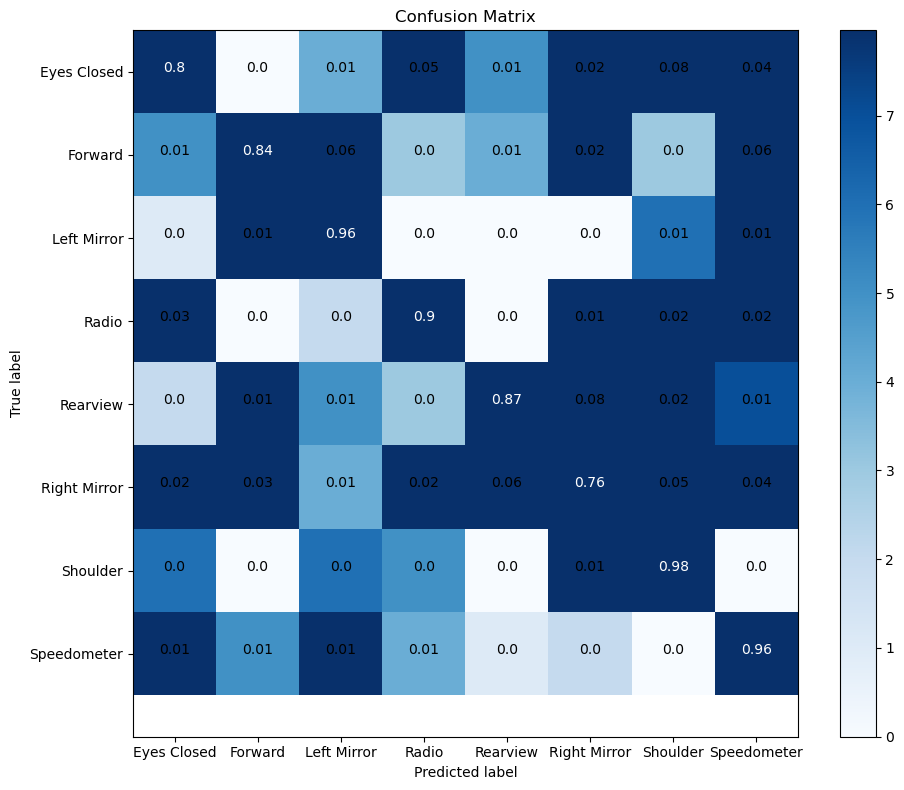

In [25]:
plot_confusion_matrix(model,dataloaders['validation'],8)